In [ ]:
# THE CONSUMER PRICE INDEX (CPI) IS A MEASURE OF THE AVERAGE CHANGE OVER TIME IN THE PRICES PAID BY URBAN CONSUMERS FOR A MARKET BASKET OF CONSUMER GOODS AND SERVICES.
# IN THIS CPI SERIES INDEX WE ARE LOOKING AT MEDICAAL CARE CPI OVER THE PAST 10 YEAR PERIOD - INCREASE CPI = INFLATION = RISING COST OF LIVING
# TIME SERIES FORECASTING WITH ARIMA MODELING IS STATISTICAL AND PREDICTIVE APPROACH OF SEEING THE FUTURE BASED ON HISTORICAL DATA

In [ ]:
#ALL THE PACKAGES I HAVE CAME ACROSS WHICH CAN DO MANY DIFFERET WAYS OF VIZUALIZATION IN PYTHON

import requests
import json
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# SECTION OF CODE WHERE I CONNECT TO THE BLS.GOV API FOR CPI DATA
BLS_API_KEY = 'f25896f3a6d24c739dff89912a87b169'

headers = {'Content-type': 'application/json'}
data = {
    "seriesid": ["CUUR0000SAM"],
    "startyear": "2014",
    "endyear": "2025",
    "registrationkey": BLS_API_KEY
}


response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=data, headers=headers)
json_data = response.json()

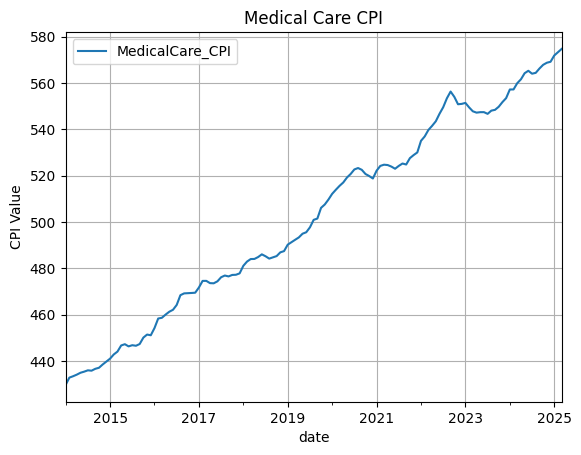

In [ ]:
# THERE ARE MULTIPLE WAYS OF SAVING THE VARIOUS FIELDS FROM THE API. A SIMPLE LINE CHART OF MEDICAL CARE CPI.

series_data = json_data['Results']['series'][0]['data']
df = pd.DataFrame(series_data)
df['value'] = df['value'].astype(float)
df['date'] = pd.to_datetime(df['year'] + '-' + df['period'].str[1:] + '-01')
df = df[['date', 'value']].sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.rename(columns={'value': 'MedicalCare_CPI'}, inplace=True)

# Plot
df.plot(title='Medical Care CPI')
plt.ylabel('CPI Value')
plt.grid(True)
plt.show()

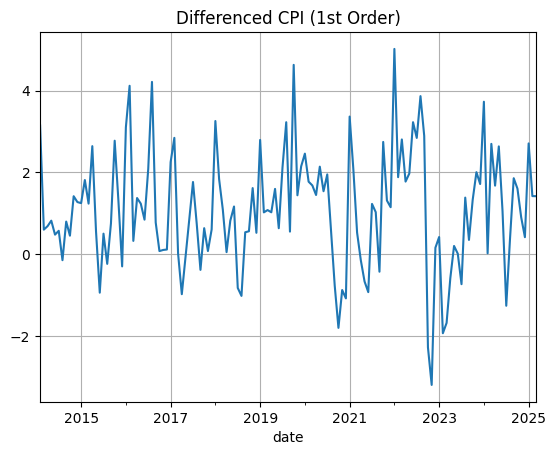

In [ ]:
# THE FIRST DIFFERENCING - WHAT I AM LOOKING FOR IS A FLAT MEAN AND VARIANCE OVER TIME. NO CLEAR TRENDS OR SEASONALITY.
# No Trend: The data fluctuates around a relatively constant mean.
# Constant Variance: The ups and downs should be roughly the same size over time.
# Random Noise Appearance: It looks more like a flat, unpredictable series — no obvious patterns.
# ADF Test p-value < 0.05: Statistically confirms stationarity.
# IF FINANCIAL DATA, RULE OF THUMB IS THAT THE DATA ALWAYS NEEDS TO BE DIFFERENCED AT LEAST ONCE. CPI IS THAT.

ts = df['MedicalCare_CPI']
ts_diff = ts.diff().dropna()

ts_diff.plot(title='Differenced CPI (1st Order)')
plt.grid(True)
plt.show()

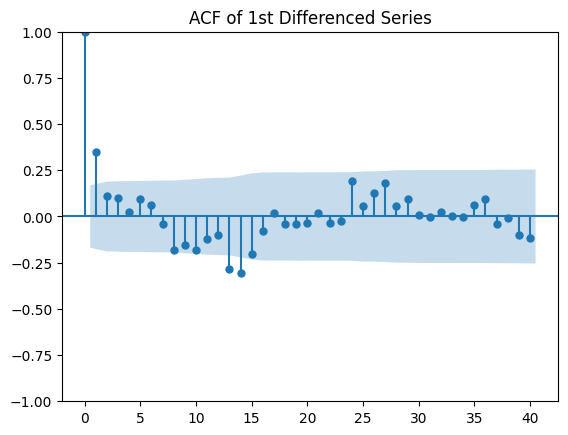

In [ ]:
#ACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_acf(ts_diff, lags=40)
plt.title("ACF of 1st Differenced Series")
plt.show()

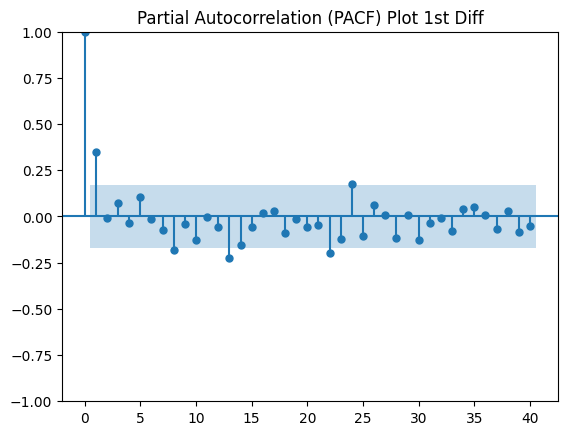

In [ ]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 1st Diff")
plt.show()

In [ ]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.033488803674096
p-value: 1.9302032110046e-12


In [ ]:
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
forecast_1_result = model_fit.get_forecast(steps=12)
forecast_1 = forecast_1_result.predicted_mean
conf_int = forecast_1_result.conf_int()
residuals = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [ ]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.010427        1.0


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [ ]:
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.006360   0.936438
2   0.008175   0.995921
3   0.008633   0.999787
4   0.008773   0.999990
5   0.009055   1.000000
6   0.009153   1.000000
7   0.010060   1.000000
8   0.010062   1.000000
9   0.010235   1.000000
10  0.010427   1.000000
11  0.010431   1.000000
12  0.010435   1.000000
13  0.010496   1.000000
14  0.010784   1.000000
15  0.011548   1.000000
16  0.013535   1.000000
17  0.018946   1.000000
18  0.019080   1.000000
19  0.020418   1.000000
20  0.020420   1.000000


In [ ]:
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_1.index = forecast_index
conf_int.index = forecast_index

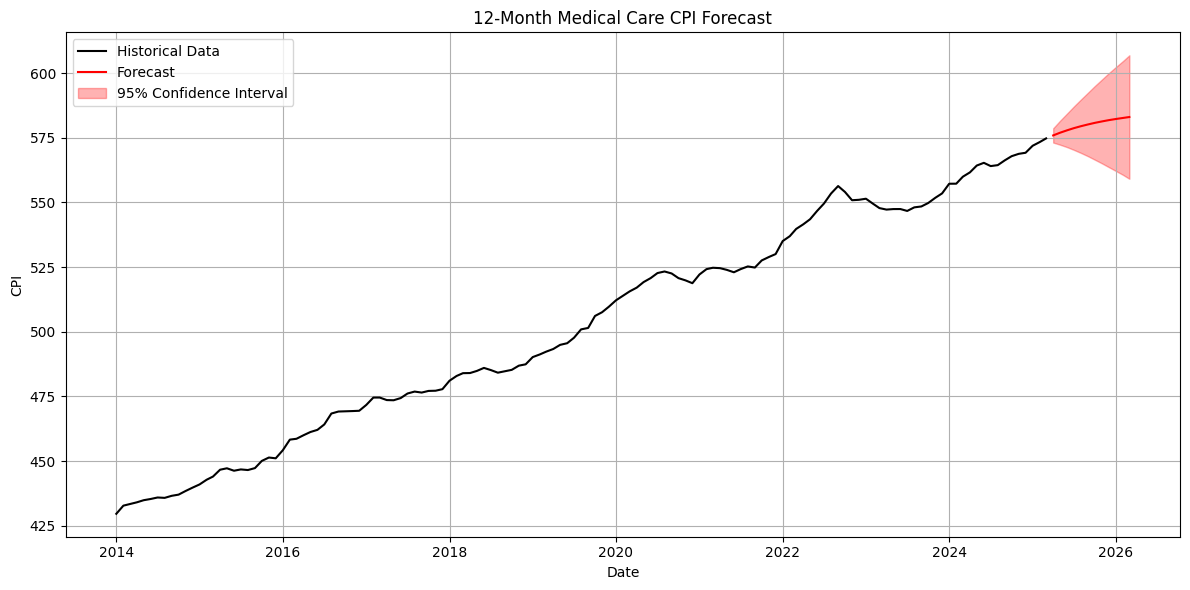

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_1, label='Forecast', color='red')
plt.fill_between(forecast_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Medical Care CPI Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Forecast with 1st Differencing:")
print(forecast_1)

Forecast with 1st Differencing:
2025-04-01    575.894398
2025-05-01    576.933548
2025-06-01    577.868146
2025-07-01    578.708712
2025-08-01    579.464706
2025-09-01    580.144638
2025-10-01    580.756160
2025-11-01    581.306155
2025-12-01    581.800813
2026-01-01    582.245703
2026-02-01    582.645831
2026-03-01    583.005701
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_1,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})



In [ ]:
print(forecast_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-04-01  575.894398      573.136335      578.652460
2025-05-01  576.933548      572.309536      581.557560
2025-06-01  577.868146      571.367699      584.368593
2025-07-01  578.708712      570.296135      587.121289
2025-08-01  579.464706      569.112145      589.817267
2025-09-01  580.144638      567.836264      592.453012
2025-10-01  580.756160      566.487265      595.025054
2025-11-01  581.306155      565.081304      597.531006
2025-12-01  581.800813      563.631999      599.969627
2026-01-01  582.245703      562.150748      602.340658
2026-02-01  582.645831      560.647052      604.644610
2026-03-01  583.005701      559.128818      606.882583


In [ ]:
# MY CONCLUSION AFTER DOING THE FIRST DIFFERENCING. MEDICAL CARE BASED ON CPI
# STILL HAS WHITE NOISE IN THE ACF AND PACF PLOTS, BUT...
# THE ADF AND LJUNG-BOX TEST P-VALUES TELL US THE MODEL HAS GOOD ENOUGH DATA FOR THE FORECAST
# NO NEED TO CONTINUE DIFFERENCING THE DATA AS IT IS STATIONARY IN THIS MODEL AFTER DIFFERENCING